In [1]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as graph
import seaborn as sns

from multiprocessing import cpu_count

from rosey.helpers import vec_to_array
from rosey.graphing import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV

from xgboost import XGBClassifier

import keras
import keras.losses as klosses
import keras.optimizers as kopt
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# %env KERAS_BACKEND=theano
# %env THEANO_FLAGS=device=cuda3,floatX=float32,optimizer=fast_run

graph.style.use('fivethirtyeight')

warnings.simplefilter('ignore')

def plot_number(xi, yi=''):
    graph.figure(figsize=(1, 1))
    graph.title('{}'.format(yi))
    graph.imshow(xi.reshape(28, 28), cmap='Greys')
    graph.xticks([])
    graph.yticks([])
    graph.grid(False)
    graph.show()

/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
df = pd.read_csv('data/digit-recognizer/train.csv')

y = df.pop('label')
x = df.values
x = MinMaxScaler().fit_transform(x)
print(y.shape, x.shape)

y_train, y_test, x_train, x_test = train_test_split(y, x, test_size=0.10)
_ = [print(a.shape) for a in (y_train, y_test, x_train, x_test)]

(42000,) (42000, 784)
(37800,)
(4200,)
(37800, 784)
(4200, 784)


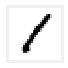

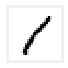

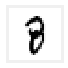

In [3]:
plot_number(x[0, :])
plot_number(x[39370, :])
plot_number(x[17521, :])

# Simple Autoencoder

In [4]:
# Simple Autoencoder
input_layer = Input(shape=(x.shape[1],))

encoder_layer = Dense(300, activation='elu')(input_layer)
encoder_layer = Dense(100, activation='elu')(encoder_layer)  # Bottleneck

decoder_layer = Dense(300, activation='elu')(encoder_layer)
output_layer = Dense(x.shape[1], activation='sigmoid')(decoder_layer)

# Create models
autoencoder = Model(input_layer, output_layer)
encoder = Model(input_layer, encoder_layer)

display(autoencoder.summary())

# Compile
autoencoder.compile(
    loss=klosses.binary_crossentropy,
    optimizer=kopt.RMSprop(),
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               30300     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               235984    
Total params: 531,884
Trainable params: 531,884
Non-trainable params: 0
_________________________________________________________________


None

Instructions for updating:
keep_dims is deprecated, use keepdims instead


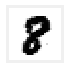

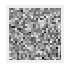

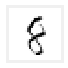

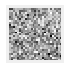

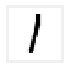

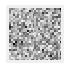

In [5]:
# Before Fitting!
for i in range(3):
    number = vec_to_array(x_train[i, :]).T

    plot_number(number)
    plot_number(autoencoder.predict(number))

Epoch Cycle 1


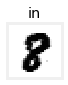

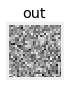

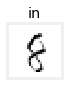

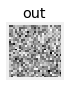

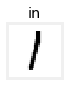

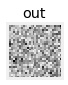

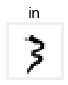

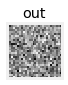

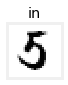

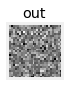


Epoch 00064: reducing learning rate to 0.0005000000237487257.

Epoch 00095: reducing learning rate to 0.0002500000118743628.


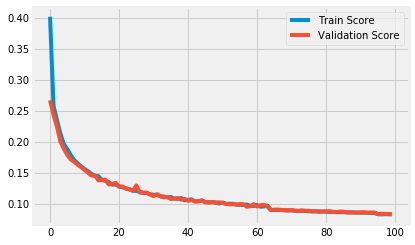

Epoch Cycle 2


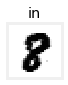

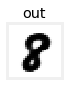

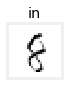

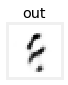

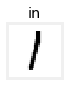

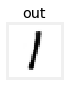

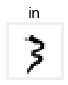

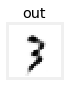

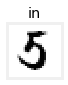

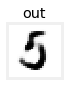


Epoch 00066: reducing learning rate to 0.0001250000059371814.

Epoch 00073: reducing learning rate to 6.25000029685907e-05.


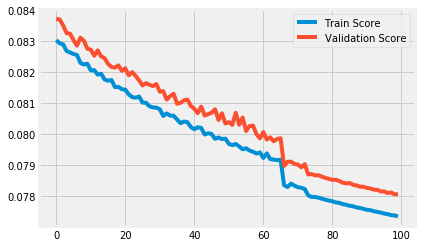

Epoch Cycle 3


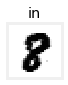

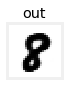

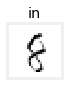

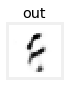

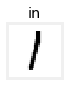

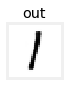

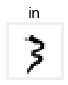

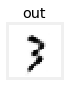

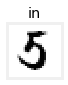

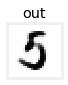


Epoch 00010: reducing learning rate to 3.125000148429535e-05.

Epoch 00017: reducing learning rate to 1.5625000742147677e-05.

Epoch 00024: reducing learning rate to 7.812500371073838e-06.

Epoch 00029: reducing learning rate to 3.906250185536919e-06.

Epoch 00038: reducing learning rate to 1.9531250927684596e-06.

Epoch 00043: reducing learning rate to 1e-06.


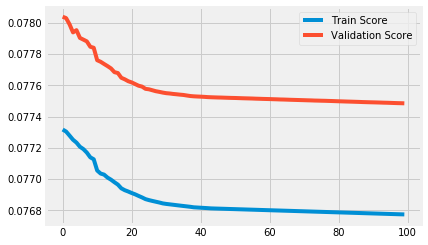

Epoch Cycle 4


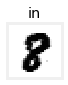

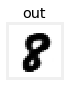

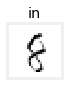

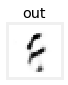

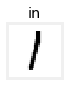

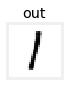

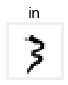

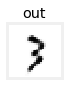

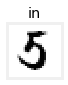

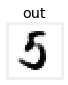

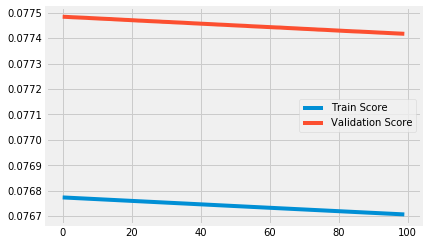

Epoch Cycle 5


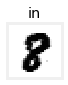

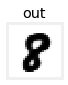

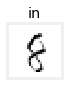

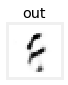

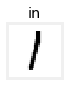

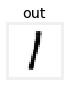

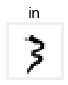

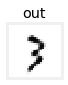

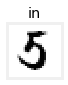

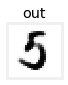

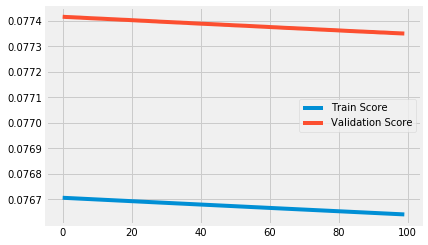

CPU times: user 2h 49min 38s, sys: 2h 20s, total: 4h 49min 59s
Wall time: 13min 13s


In [6]:
%%time
# Fit model! (n*100) epochs
for i in range(5):
    print(f'Epoch Cycle {i+1}')
    
    # Check fit
    for i_img in range(5):
        number_i = vec_to_array(x_train[i_img, :]).T
        
        plot_number(number_i, 'in')
        plot_number(autoencoder.predict(number_i), 'out')
    
    # Train
    hist = autoencoder.fit(
        x_train, x_train,
        epochs=100, validation_data=(x_test, x_test), batch_size=4096,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=15),
            ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6, verbose=1),
            # TQDMCallback(),
            ModelCheckpoint('data/model.ckp', monitor='val_loss', save_best_only=True)
        ],
        shuffle=True,
        verbose=0
    )
    
    # Summary of performance
    graph.plot(hist.history['loss'], label='Train Score')
    graph.plot(hist.history['val_loss'], label='Validation Score')
    graph.legend()
    graph.show()

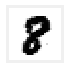

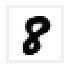

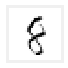

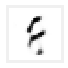

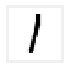

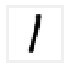

In [7]:
# After Fitting!
for i in range(3):
    number = vec_to_array(x_train[i, :]).T

    plot_number(number)
    plot_number(autoencoder.predict(number))

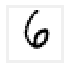

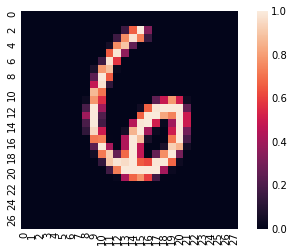

Representation


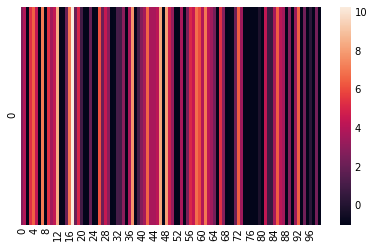

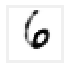

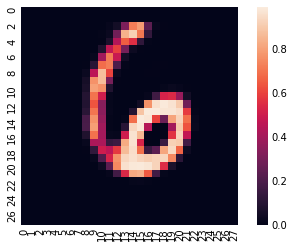

In [8]:
new_number = vec_to_array(x_test[1013, :]).T

plot_number(new_number)

sns.heatmap(new_number.reshape((28, 28)), square=True)
graph.show()

print('Representation')
sns.heatmap(encoder.predict(new_number))
graph.show()

print('')
plot_number(autoencoder.predict(new_number))

sns.heatmap(autoencoder.predict(new_number).reshape((28, 28)), square=True)
graph.show()

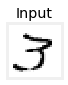

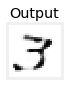

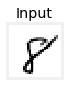

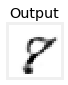

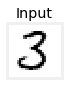

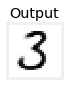

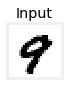

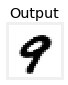

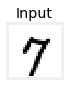

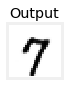

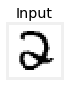

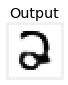

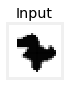

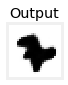

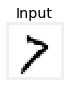

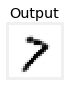

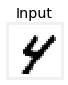

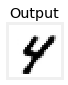

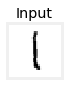

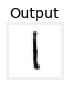

In [9]:
# Test set fits!
for i in range(10):
    number = vec_to_array(x_test[i, :]).T

    plot_number(number, 'Input')
    plot_number(autoencoder.predict(number), 'Output')

# Predicting Numbers

I'm going to use the representations as the features for predicting which number is being represented.

In [10]:
# L stands for latent representation
l_train, l_test = [encoder.predict(data) for data in (x_train, x_test)]

print(l_train.shape, l_test.shape)

(37800, 100) (4200, 100)


In [11]:
%%time
logit = LogisticRegressionCV(Cs=25, cv=2, penalty='l2', n_jobs=-1, multi_class='multinomial')
logit.fit(l_train, y_train)

CPU times: user 5.21 s, sys: 1.44 s, total: 6.65 s
Wall time: 57.9 s


In [12]:
%%time
gbm = XGBClassifier(n_estimators=4000, n_jobs=cpu_count())
gbm.fit(l_train, y_train)

CPU times: user 7h 3min 36s, sys: 212 ms, total: 7h 3min 36s
Wall time: 9min


In [13]:
# Scores
print(f'Raw = {logit.score(l_test, y_test)}')
print(f'XGB = {gbm.score(l_test, y_test)}')

Raw = 0.9130952380952381
XGB = 0.9642857142857143


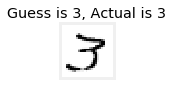

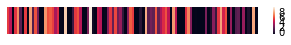

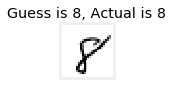

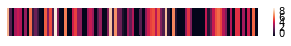

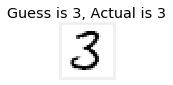

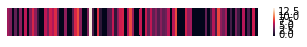

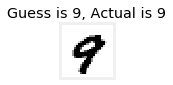

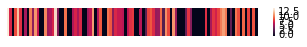

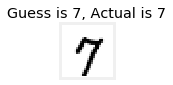

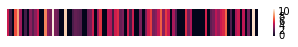

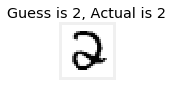

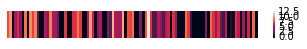

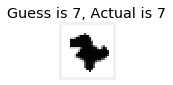

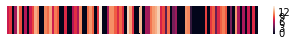

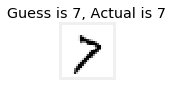

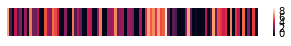

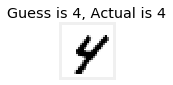

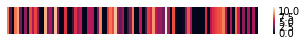

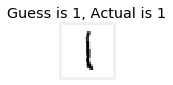

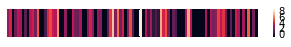

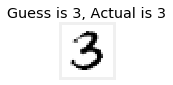

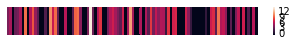

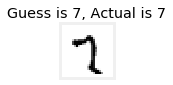

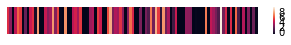

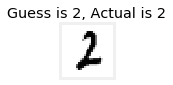

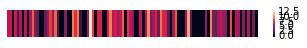

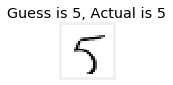

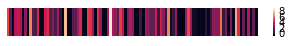

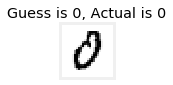

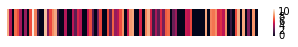

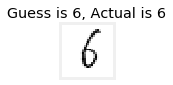

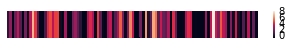

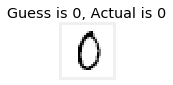

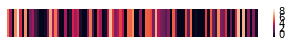

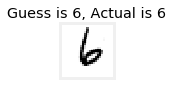

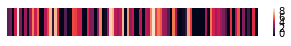

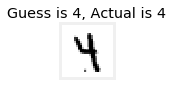

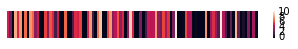

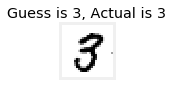

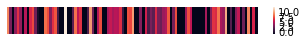

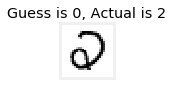

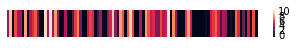

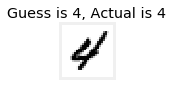

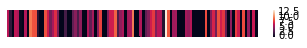

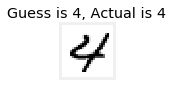

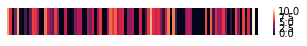

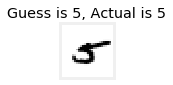

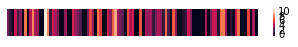

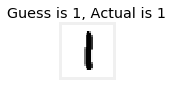

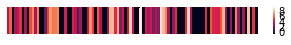

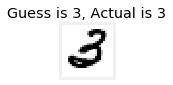

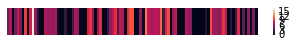

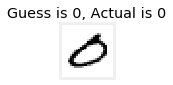

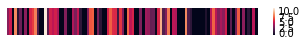

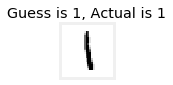

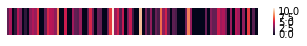

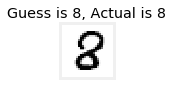

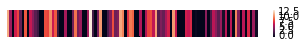

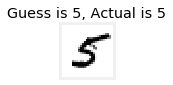

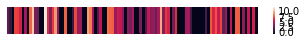

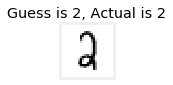

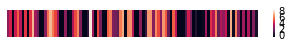

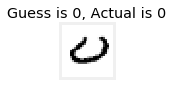

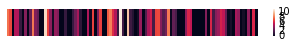

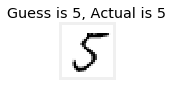

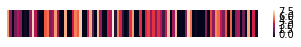

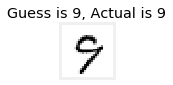

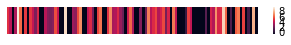

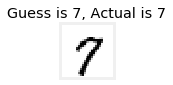

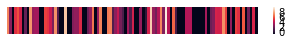

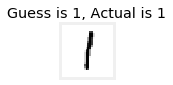

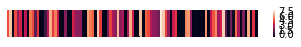

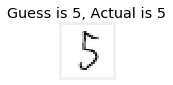

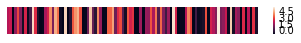

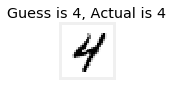

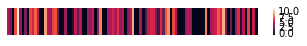

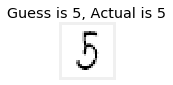

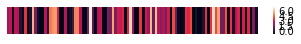

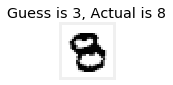

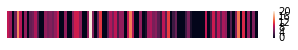

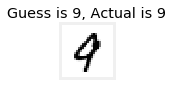

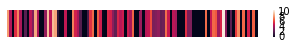

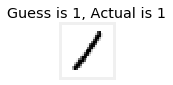

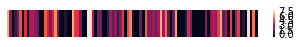

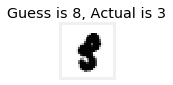

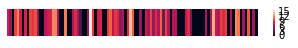

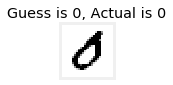

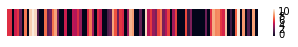

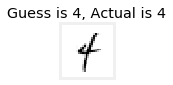

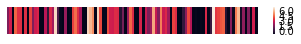

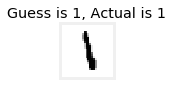

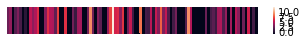

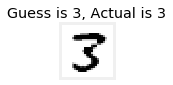

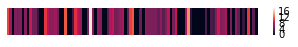

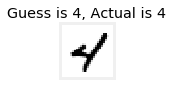

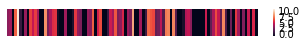

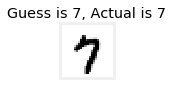

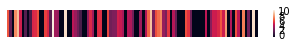

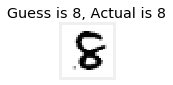

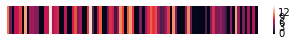

In [14]:
for pos in range(50):
    number = x_test[pos, :]
    latent = vec_to_array(l_test[pos, :]).T
    label = y_test.values[pos]
    
    plot_number(number, f'Guess is {gbm.predict(latent)[0]}, Actual is {label}')
    
    graph.figure(figsize=(5, .5))
    sns.heatmap(latent)
    graph.xticks([])
    graph.yticks([])
    graph.show()

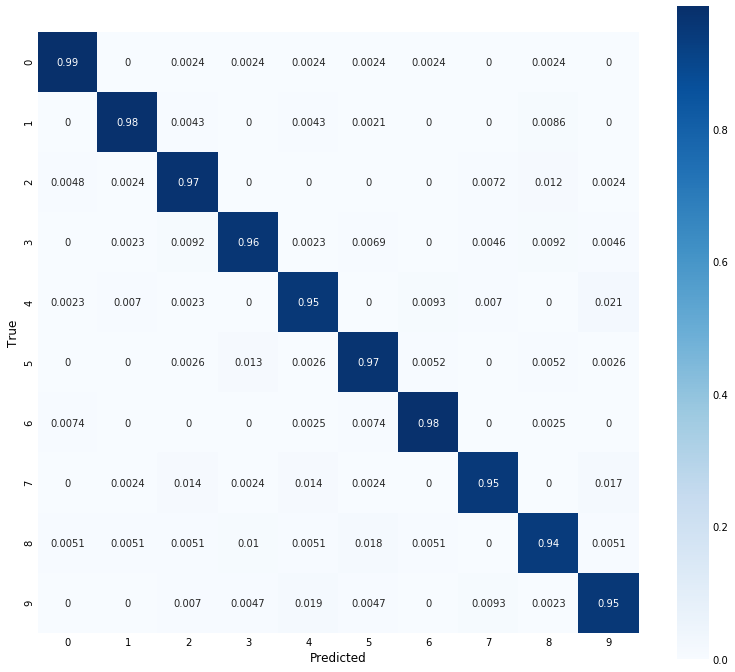

In [15]:
graph.figure(figsize=(12, 12))
plot_confusion_matrix(y_test, gbm.predict(l_test))
graph.show()